# Closed shell reactions with core correlation

Bak et al., [doi:10.1063/1.1357225](https://doi.org/10.1063/1.1357225) and [doi:10.1063/1.481544](https://doi.org/10.1063/1.481544)

In [1]:
import pymolpro
import pandas as pd

In [2]:
backend = 'local' # If preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
project_name = 'Core_Valence_reactions'
# parallel = 7 # how many jobs to run at once

In [3]:
methods = ['HF','MP2', 'CCSD', 'CCSD(T)']
bases = ['cc-pCVDZ','cc-pCVTZ','cc-pCVQZ', 'cc-pCV5Z']

In [4]:
closed_shell_methods={'B3LYP' : "ks, b3lyp", "HF" : "hf", "MP2":"mp2","MP3":"mp3","MP4":"mp4","CCSD":"ccsd","CCSD(T)":"ccsd(t)", "PAPT2":"papt;mp2", "PAPT3":"papt;mp3", "PAPT4":"papt;mp4"}

In [5]:
db=pymolpro.database.library("Bak2000_reactions")

In [6]:
results={}
for method in methods:
    results[method]={}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(db,method,basis,location=project_name,backend=backend,preamble="core,small")

## Extrapolation

In [7]:
extrapolations={}
if 'cc-pCVDZ' in bases and 'cc-pCVTZ' in bases:
    extrapolations["DT"]={'x':2, 'first':'cc-pCVDZ', 'second':'cc-pCVTZ'}
if 'cc-pCVTZ' in bases and 'cc-pCVQZ' in bases:
    extrapolations["TQ"]={'x':3, 'first':'cc-pCVTZ', 'second':'cc-pCVQZ'}
if 'cc-pCVQZ' in bases and 'cc-pCV5Z' in bases:
    extrapolations["Q5"]={'x':4, 'first':'cc-pCVQZ', 'second':'cc-pCV5Z'}

for extr in extrapolations:
    x=extrapolations[extr]['x']
    xbas=extrapolations[extr]['first']
    xpbas=extrapolations[extr]['second']
    for method in methods:
        results[method][extr]=pymolpro.database.basis_extrapolate(
            [results[method][xbas],results[method][xpbas]],
            [results['HF'][xbas],results['HF'][xpbas]],
            [x,x+1]
        )
    bases.append(extr) if extr not in bases else ""


In [8]:
pd.set_option('display.precision', 2)
pymolpro.database.compare([results[method]['cc-pCV5Z'] for method in methods],db.reference_results())['reaction statistics']*2625.499

,HF,MP2,CCSD,CCSD(T)
,cc-pCV5Z,cc-pCV5Z,cc-pCV5Z,cc-pCV5Z
mean,9.25,-10.49,-5.78,0.39
stdev,41.24,18.17,9.20,1.51
meanabs,29.06,14.46,9.37,1.30
maxabs,113.66,50.01,17.72,3.00


In [9]:
pd.set_option('display.precision', 2)
pymolpro.database.compare([results['CCSD(T)'][basis] for basis in bases],db.reference_results())['reaction statistics']*2625.499

CCSD(T)                                                     \
        cc-pCVDZ cc-pCVTZ cc-pCVQZ cc-pCV5Z cc-pCV[23]Z cc-pCV[34]Z   
mean       33.39    11.31     3.02     0.39        2.70       -1.13   
stdev      25.92     8.07     2.88     1.51        4.83        1.23   
meanabs    36.73    12.05     3.70     1.30        4.37        1.33   
maxabs     65.92    21.33     6.97     3.00       10.79        3.15   

                     
        cc-pCV[45]Z  
mean          -0.83  
stdev          1.22  
meanabs        1.19  
maxabs         3.49

NameError: name 'error_with_respect_to_experimental_enthalpy' is not defined

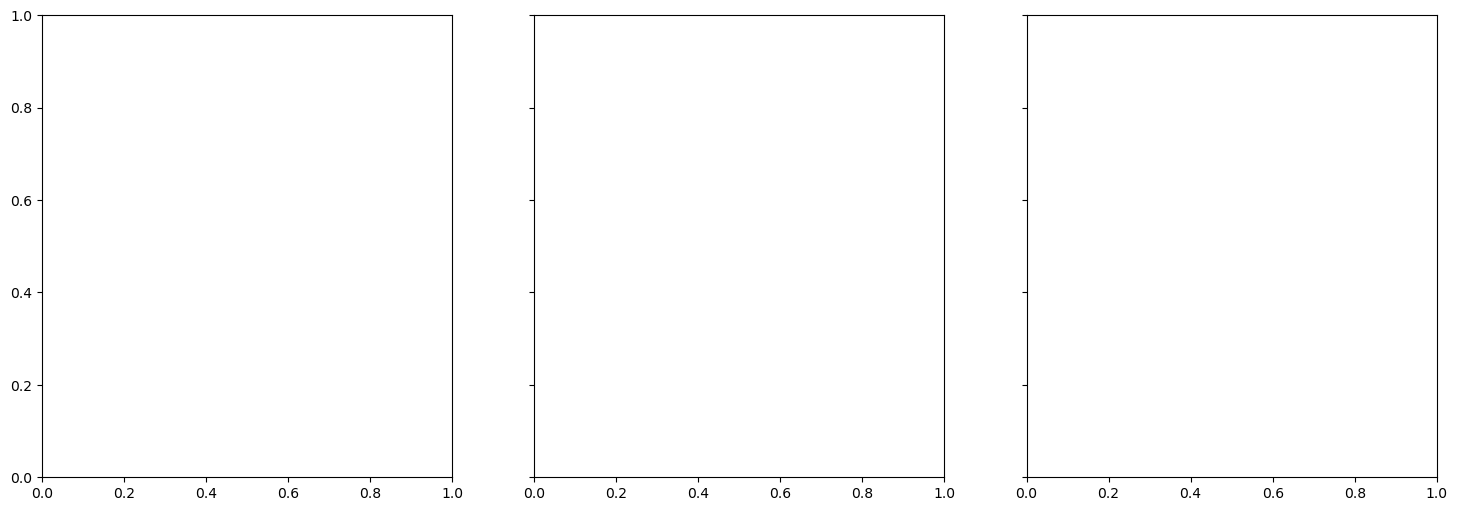

In [10]:
import matplotlib.pyplot as plt
methods_pruned = [method for method in methods if method != 'HF']
bases_pruned = ['cc-pCV5Z','TQ','Q5']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18,6))

for pane in range(len(bases_pruned)):
    data=[]
    for method in methods_pruned:
        data.append(list(error_with_respect_to_experimental_enthalpy[bases_pruned[pane]][method].values()))
    panes[pane].violinplot(data,showmeans=True,showextrema=True,vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1,len(methods_pruned)+1),labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name+".violin.pdf")

## Calculated enthalpy changes

In [ ]:
reactions={}
reactions["1"] = {"CO" : -1, "H2" : -1, "CH2O" : +1}
reactions["2"] = {"N2" : -1, "H2" : -3, "NH3" : +2}
reactions["3"] = {"C2H2" : -1, "H2" : -1, "C2H4" : +1}
reactions["4"] = {"CO2" : -1, "H2" : -4, "CH4" : +1, "H2O" : +2}
reactions["5"] = {"CH2O" : -1, "H2" : -2, "CH4" : +1, "H2O" : +1}
reactions["6"] = {"CO" : -1, "H2" : -3, "CH4" : +1, "H2O" : +1}
reactions["7"] = {"HCN" : -1, "H2" : -3, "CH4" : +1, "NH3" : +1}
reactions["8"] = {"H2O2" : -1, "H2" : -1, "H2O" : +2}
reactions["9"] = {"HNO" : -1, "H2" : -2, "H2O" : +1, "NH3" : +1}
reactions["10"] = {"C2H2" : -1, "H2" : -3, "CH4" : +2}
reactions["11"] = {"CH2" : -1, "H2" : -1, "CH4" : +1}
reactions["12"] = {"F2" : -1, "H2" : -1, "HF" : +2}
reactions["13"] = {"CH2" : -2, "C2H4" : +1}

In [ ]:
Molpro_enthalpy={}
for method in methods:
    Molpro_enthalpy[method]={}
    for basis in bases:
        Molpro_enthalpy[method][basis]={}
        for name in reactions:
            reaction_enthalpy_au = 0
            for molecule in reactions[name]:
                reaction_enthalpy_au += energies[method][basis][molecule] * reactions[name][molecule]
            reaction_enthalpy_kjmol = reaction_enthalpy_au * 2625.49963948
            Molpro_enthalpy[method][basis][name] =+ reaction_enthalpy_kjmol
            

## Reference experimental and calculated reaction enthalpy changes 

In [ ]:
Exp_enthalpy={}
for name in reactions:
    reaction_enthalpy_kjmol = 0
    for molecule in reactions[name]:
        reaction_enthalpy_kjmol -= molecules[molecule]["De_exp"] * reactions[name][molecule]
    Exp_enthalpy[name] =+ reaction_enthalpy_kjmol

In [ ]:
Calc_enthalpy={}
for name in reactions:
    reaction_enthalpy_kjmol = 0
    for molecule in reactions[name]:
        reaction_enthalpy_kjmol -= molecules[molecule]["De_calc"] * reactions[name][molecule]
    Calc_enthalpy[name] =+ reaction_enthalpy_kjmol

## Statistical analysis of calculated enthalpy changes

In [ ]:
def collect_errors(reference_data):
    e={}
    for basis in bases:
        e[basis]={}
        for method in methods:
            e[basis][method]={}
            for reaction in reactions:
                e[basis][method][reaction] = Molpro_enthalpy[method][basis][reaction] - reference_data[reaction]
    return e
error_with_respect_to_experimental_enthalpy=collect_errors(Exp_enthalpy)
error_with_respect_to_calculated_enthalpy=collect_errors(Calc_enthalpy)

In [ ]:
methods_pruned = methods[1:]
bases_pruned = ['cc-pCV5Z','TQ','Q5']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18,6))

for pane in range(len(bases_pruned)):
    data=[]
    for method in methods_pruned:
        data.append(list(error_with_respect_to_experimental_enthalpy[bases_pruned[pane]][method].values()))
    panes[pane].violinplot(data,showmeans=True,showextrema=True,vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1,len(methods_pruned)+1),labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name+".violin.pdf")

### Mean error

In [ ]:
def error(method, basis, name):
    return Molpro_enthalpy[method][basis][name]-Exp_enthalpy[name]

lit_exp_molpro_error={}
for name in reactions:
    lit_exp_molpro_error[name]={}
    for method in methods:
        lit_exp_molpro_error[name][method]={}
        for basis in bases:
            lit_exp_molpro_error[name][method][basis]={}
            test_enthalpy = Molpro_enthalpy[method][basis][name]
            comparison_enthalpy = Exp_enthalpy[name]
            error = test_enthalpy - comparison_enthalpy
            lit_exp_molpro_error[name][method][basis] =+ error

lit_exp_molpro_meanerror={}
for method in methods:
    lit_exp_molpro_meanerror[method]={}
    for basis in bases:
        lit_exp_molpro_meanerror[method][basis]={}
        error_sum = 0
        for name in reactions:
            error_sum += lit_exp_molpro_error[name][method][basis]
        mean_error = error_sum / len(reactions)
        lit_exp_molpro_meanerror[method][basis] =+ mean_error

In [ ]:
df_exp_reaction_meanerror=pd.DataFrame(data=lit_exp_molpro_meanerror)
df_exp_reaction_meanerror.style.set_caption("Mean error")

### Mean absolute error

In [ ]:
lit_exp_molpro_abserror={}
for name in reactions:
    lit_exp_molpro_abserror[name]={}
    for method in methods:
        lit_exp_molpro_abserror[name][method]={}
        for basis in bases:
            lit_exp_molpro_abserror[name][method][basis]={}
            test_enthalpy = Molpro_enthalpy[method][basis][name]
            comparison_enthalpy = Exp_enthalpy[name]
            error = abs(test_enthalpy - comparison_enthalpy)
            lit_exp_molpro_abserror[name][method][basis] =+ error


lit_exp_molpro_meanabserror={}
for method in methods:
    lit_exp_molpro_meanabserror[method]={}
    for basis in bases:
        lit_exp_molpro_meanabserror[method][basis]={}
        error_sum = 0
        for name in reactions:
            error_sum += lit_exp_molpro_abserror[name][method][basis]
        mean_error = error_sum / len(reactions)
        lit_exp_molpro_meanabserror[method][basis] =+ mean_error

In [ ]:
df_exp_reaction_meanabserror=pd.DataFrame(data=lit_exp_molpro_meanabserror)
df_exp_reaction_meanabserror.style.set_caption("Mean absolute error")

### Maximum error

In [ ]:
lit_exp_molpro_maxerror={}
for method in methods:
    lit_exp_molpro_maxerror[method]={}
    for basis in bases:
        lit_exp_molpro_maxerror[method][basis]={}
        max_error = 0
        for name in reactions:
            if abs(lit_exp_molpro_error[name][method][basis]) > abs(max_error):
                max_error = lit_exp_molpro_error[name][method][basis]
        lit_exp_molpro_maxerror[method][basis] =+ max_error

In [ ]:
df_exp_reaction_maxerror=pd.DataFrame(data=lit_exp_molpro_maxerror)
df_exp_reaction_maxerror.style.set_caption("Maximum error")

### Standard deviation

In [ ]:
lit_exp_molpro_std={}
for method in methods:
    lit_exp_molpro_std[method]={}
    for basis in bases:
        lit_exp_molpro_std[method][basis]={}
        sum_squared_errors = 0
        for name in reactions:
            squared_error = (lit_exp_molpro_error[name][method][basis] - lit_exp_molpro_meanerror[method][basis]) ** 2
            sum_squared_errors += squared_error
        SD_squared = sum_squared_errors / (len(reactions)-1)
        SD = np.sqrt(SD_squared)
        lit_exp_molpro_std[method][basis] = SD

In [ ]:
df_exp_reaction_std=pd.DataFrame(data=lit_exp_molpro_std)
df_exp_reaction_std.style.set_caption("Standard deviation of errors")

In [ ]:
with open(project_name+'.tex','w') as tf:
    tf.write('\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}')
    tf.write(df_exp_reaction_meanerror.style.to_latex())
    tf.write(df_exp_reaction_std.style.to_latex())
    tf.write(df_exp_reaction_meanabserror.style.to_latex())
    tf.write(df_exp_reaction_maxerror.style.to_latex())